In [2]:
from math import *
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D


## Matrix Class

In [3]:
class matrix:
    
    # implements basic operations of a matrix class
    
    def __init__(self, value):
        self.value = value
        self.dimx = len(value)
        if type(value[0]) is list:
            self.dimy = len(value[0])
        else:
            self.dimy = 1
        if value == [[]]:
            self.dimx = 0
    
    def zero(self, dimx, dimy):
        # check if valid dimensions
        if dimx < 1 or dimy < 1:
            raise(ValueError, "invalid size of matrix")
        else:
            self.dimx = dimx
            self.dimy = dimy
            self.value = [[0 for row in range(dimy)] for col in range(dimx)]
    
    def identity(self, dim):
        # check if valid dimension
        if dim < 1:
            raise(ValueError, "Invalid size of matrix")
        else:
            self.dimx = dim
            self.dimy = dim
            self.value = [[0 for row in range(dim)] for col in range(dim)]
            for i in range(dim):
                self.value[i][i] = 1
    
    def show(self):
        for i in range(self.dimx):
            print(self.value[i])
        print(' ')
    
    def __add__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise(ValueError, "Matrices must be of equal dimensions to add")
        else:
            # add if correct dimensions
            res = matrix([[]])
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] + other.value[i][j]
            return res
    
    def __sub__(self, other):
        # check if correct dimensions
        if self.dimx != other.dimx or self.dimy != other.dimy:
            raise(ValueError, "Matrices must be of equal dimensions to subtract")
        else:
            # subtract if correct dimensions
            res = matrix([[]])
            res.zero(self.dimx, self.dimy)
            for i in range(self.dimx):
                for j in range(self.dimy):
                    res.value[i][j] = self.value[i][j] - other.value[i][j]
            return res
    
    def __mul__(self, other):
        # check if correct dimensions
        if self.dimy != other.dimx:
            raise(ValueError, "Matrices must be m*n and n*p to multiply self.dy:", self.dimy," other.dimx:", other.dimx)
        else:
            # subtract if correct dimensions
            res = matrix([[]])
            res.zero(self.dimx, other.dimy)
            for i in range(self.dimx):
                for j in range(other.dimy):
                    for k in range(self.dimy):
                        res.value[i][j] += self.value[i][k] * other.value[k][j]
            return res
    
    def transpose(self):
        # compute transpose
        res = matrix([[]])
        res.zero(self.dimy, self.dimx)
        for i in range(self.dimx):
            for j in range(self.dimy):
                res.value[j][i] = self.value[i][j]
        return res
    
    # Thanks to Ernesto P. Adorio for use of Cholesky and CholeskyInverse functions
    
    def Cholesky(self, ztol=1.0e-5):
        # Computes the upper triangular Cholesky factorization of
        # a positive definite matrix.
        res = matrix([[]])
        res.zero(self.dimx, self.dimx)
        
        for i in range(self.dimx):
            S = sum([(res.value[k][i])**2 for k in range(i)])
            d = self.value[i][i] - S
            if abs(d) < ztol:
                res.value[i][i] = 0.0
            else:
                if d < 0.0:
                    raise(ValueError, "Matrix not positive-definite")
                res.value[i][i] = sqrt(d)
            for j in range(i+1, self.dimx):
                S = sum([res.value[k][i] * res.value[k][j] for k in range(self.dimx)])
                if abs(S) < ztol:
                    S = 0.0
                try:
                   res.value[i][j] = (self.value[i][j] - S)/res.value[i][i]
                except:
                   raise(ValueError, "Zero diagonal")
        return res
    
    def CholeskyInverse(self):
        # Computes inverse of matrix given its Cholesky upper Triangular
        # decomposition of matrix.
        res = matrix([[]])
        res.zero(self.dimx, self.dimx)
        
        # Backward step for inverse.
        for j in reversed(range(self.dimx)):
            tjj = self.value[j][j]
            S = sum([self.value[j][k]*res.value[j][k] for k in range(j+1, self.dimx)])
            res.value[j][j] = 1.0/tjj**2 - S/tjj
            for i in reversed(range(j)):
                res.value[j][i] = res.value[i][j] = -sum([self.value[i][k]*res.value[k][j] for k in range(i+1, self.dimx)])/self.value[i][i]
        return res
    
    def inverse(self):
        aux = self.Cholesky()
        res = aux.CholeskyInverse()
        return res
    
    def __repr__(self):
        return repr(self.value)

## Error Ellipse

In [33]:
import numpy as np
import math
from scipy.stats import chi2
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

class ErrorEllipse2D:
    def __init__(self, error_mat, kaisq):
        self.error_mat = error_mat


        self.SetKaiSQParam(kaisq)

        #print(self.ramda1,",",self.ramda2,",",self.kaisq)
    
    def SetKaiSQParam(self, kaisq):
        self.kaisq = kaisq

    def GetEllipseParam(self):

        cov_mat = np.matrix([
                            [self.error_mat.value[0][0], self.error_mat.value[0][1]],
                            [self.error_mat.value[1][0], self.error_mat.value[1][1]]
                            ])
        self.cov = cov_mat
        lambdas, vecs = np.linalg.eigh(cov_mat)

        c = np.sqrt(chi2.ppf(self.kaisq, 2))
        #print("c:", c)

        self.w, self.h = 2 * c * np.sqrt(lambdas)
        self.theta = np.degrees(np.arctan2(lambdas[0]-lambdas[1], self.cov[0,1]))

        #print("W:", self.w," H:", self.h, " theta:", self.theta, "[deg]")


    
    
    def GetEllipsePoints(self, x, y, color="limegreen", alpha=0.8):
        self.GetEllipseParam()
        el = Ellipse(xy=[x,y], width=self.w, height=self.h, angle=self.theta, color=color, alpha=alpha, fc="None")
        return(el)




## Kalman Filter Class

In [50]:
class KalmanFilter():
    def __init__(self):
        x = ""
        P = ""
        x_est = ""
        P_est = ""
        F = ""
        H = ""
        R = ""
        I = ""
        Q = ""
        u = ""
        z = ""
    
    
    def MeasurementUpdate(self, measurement):
        # 観測値
        self.z = np.array([measurement])
        
        # 1step前との差分
        self.y = self.z.T - np.dot(self.H, self.x)
        

        # 
        #S = (self.H * self.P) * self.H.transpose() + self.R
        self.S = np.dot(np.dot(self.H , self.P), self.H.transpose()) + self.R

        #
        #K = (self.P * self.H.transpose()) * S.inverse()
        self.K = np.dot(np.dot(self.P , self.H.T) , np.linalg.inv(self.S))
        
        print("Measurement:")
        print("P before:", self.P)
        print("K:", self.K)
        print("H:", self.H)

        self.x = self.x + np.dot(self.K, self.y)
        self.P = np.dot((self.I - np.dot(self.K, self.H)), self.P)
        print("P after:", self.P)

        #print("x")
        #self.x.show()

        #print("P")
        #self.P.show()
    
    def Prediction(self, externalMotion):
        #self.x = (self.F * self.x) + externalMotion
        #self.P = self.F * self.P * self.F.transpose() + self.Q
        #print("Prediction:")
        #print("F:", self.F)
        #print("x:", self.x)
        #print("P before:", self.P)
        self.x = np.dot(self.F, self.x) + self.u
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        #print("P after:", self.P)
        #self.P = np.dot(np.dot(F, P), F.T) + self.Q


    def UpdatePolorMeasurement(self, polar_measurement):
        # 観測値
        self.z = np.array([polar_measurement])
        
        # 1step前との差分
        self.y = self.z.T - np.dot(self.H, self.x)
        #while self.y[1][0] > pi :
        #    self.y[1][0] -= 2 * pi

        #while self.y[1][0] < -pi:
        #    self.y[1][0] += 2 * pi
        

        # 
        #S = (self.H * self.P) * self.H.transpose() + self.R
        self.S = np.dot(np.dot(self.H , self.P), self.H.transpose()) + self.R

        #
        #K = (self.P * self.H.transpose()) * S.inverse()
        self.K = np.dot(np.dot(self.P , self.H.T) , np.linalg.inv(self.S))
        
        #print("Measurement:")
        #print("P before:", self.P)
        #print("K:", self.K)
        #print("H:", self.H)

        self.x = self.x + np.dot(self.K, self.y)
        self.P = np.dot((self.I - np.dot(self.K, self.H)), self.P)
    
    def CalcMaharanobisDist2D(self, target_pos):

        
        target =  np.matrix([[target_pos[0]], [target_pos[1]],[0], [0]])


        difference = target - self.x
        difference[2,0] = 0
        difference[3,0] = 0

        maharanobis_dist = np.dot(np.dot(difference.T, np.linalg.inv(self.P)), difference)
        return(maharanobis_dist[0,0])
    
    def CalcEuclideanDist2D(self, target_pos):
        target =  np.matrix([[target_pos[0]], [target_pos[1]],[0], [0]])
        diff_x = target_pos[0] - self.x[0][0]
        diff_y = target_pos[1] - self.x[0][1]

        dist = np.sqrt(diff_x ** 2 + diff_y ** 2)
        return(dist)

        

    def GetState(self):
        return(self.x.value)
    
    def GetUncertainity(self):
        return(self.P)
    
    def GetErrorEllipsePoints(self, kai_th):
        err_mat = matrix([[self.P[0,0], self.P[0,1]], [self.P[1,0], self.P[1,1]]])
        ellipse = ErrorEllipse2D(err_mat, kai_th)

        return(ellipse.GetEllipsePoints(self.x[0,0], self.x[1,0]))

    def GetErrorEllipsePointsWithSelectedPos(self, x, y, kai_th, color="limegreen"):
        err_mat = matrix([[self.P[0,0], self.P[0,1]], [self.P[1,0], self.P[1,1]]])
        ellipse = ErrorEllipse2D(err_mat, kai_th)

        return(ellipse.GetEllipsePoints( x, y, color=color))





## Vehicle Class

In [62]:
import random

class Vehicle:
    def __init__(self, v, w, dt):
        self._v = v
        self._w = w
        self._dt = dt
        self._x_init = 0.0
        self._y_init = 0.0
        self._theta_init = 0.0
        self._x = 0.0
        self._y = 0.0
        self._theta = 0.0
        self._vx = 0.0
        self._vy = 0.0
        self._truck_width = 7.0
        self._truck_length= 12.0

        self._pos_noise = 1.0
        self._theta_noise = 0.05

        print("theta/dt = ", 180*(w * dt)/pi)

    
    def InitPosition(self, x, y, theta):
        self._x_init = x
        self._y_init = y
        self._theta_init = theta
        self._x = x
        self._y = y
        self._theta = theta

        self._true_x = x
        self._true_y = y
        self._true_theta = theta
    
    def SetNoise(self, pos_noise, theta_noise):
        self._pos_noise = pos_noise
        self._theta_noise = theta_noise
    
    def ChangeVelocity(self, v):
        self._v = v
    
    def ChangeAngularVelocity(self, w):
        self._w = w

    def UpdateOneStep(self):
        theta = self._theta
        self._true_theta = self._true_theta + self._w * self._dt
        self._theta = self._theta + self._w * self._dt + random.uniform(-self._theta_noise, self._theta_noise)

        self._vx = self._v * cos(theta)
        self._vy = self._v * sin(theta)
        self._true_vx = self._v * cos(self._true_theta)
        self._true_vy = self._v * sin(self._true_theta)

        self._true_x = self._true_x + self._true_vx * self._dt
        self._true_y = self._true_y + self._true_vy * self._dt
        self._x = self._true_x + self._vx * self._dt + random.uniform(-self._pos_noise, self._pos_noise)
        self._y = self._true_y + self._vy * self._dt + random.uniform(-self._pos_noise, self._pos_noise)

        return [self._x,self._y,self._theta], [self._true_x, self._true_y, self._true_theta]

    def GetAllState(self):
        return([self._x, self._y, self._theta, self._vx, self._vy, self._w])
    
    def GetAllTrueState(self):
        return([self._true_x, self._true_y, self._true_theta, self._true_vx, self._true_vy, self._w])

    
    def RelativeRectangle(self, width, height, center_tf, **kwargs):
        rect_origin_to_center = Affine2D().translate(width/2 , height/2)
        #print(rect_origin_to_center)
        return(Rectangle((0,0), width, height, transform=rect_origin_to_center.inverted() + center_tf, **kwargs))
        #return(Rectangle((0,0), width, height, transform=center_tf, **kwargs))


    def PlotCurrentVehiclePosition(self, ax, **kwargs):
        ax.scatter( self._true_x, self._true_y, color="black" )

        truck_x = self._true_x
        truck_y = self._true_y
        truck_theta = self._true_theta

        rect_center_x = truck_x + self._truck_length * 0.25 * cos(truck_theta)
        rect_center_y = truck_y + self._truck_length * 0.25 * sin(truck_theta)

        to_rear_axle_tf = Affine2D().rotate(truck_theta - radians(90)).translate(truck_x, truck_y) + ax.transData
        to_body_center_tf = Affine2D().rotate(truck_theta - radians(90)).translate(rect_center_x,rect_center_y) + ax.transData
        body = self.RelativeRectangle(self._truck_width, self._truck_length, to_body_center_tf, edgecolor="black", facecolor="Yellow", **kwargs)

        tyre_width = 1.0
        tyre_length = 3.0
        front_tyre_pos_x = 0.3 * self._truck_width
        front_tyre_pos_y = 0.4 * self._truck_length
        tyre_base_angle = 0
        body_center_to_left_front_tf = Affine2D().rotate(radians(tyre_base_angle)).translate( -0.4*self._truck_width, 0.5*self._truck_length) # ステアを切る場合はrotateをいじる
        body_center_to_right_front_tf = Affine2D().rotate(radians(tyre_base_angle)).translate(0.4*self._truck_width,  0.5*self._truck_length)

        body_center_to_left_rear_tf = Affine2D().rotate(radians(tyre_base_angle)).translate( -0.4*self._truck_width, 0)
        body_center_to_right_rear_tf = Affine2D().rotate(radians(tyre_base_angle)).translate( 0.4*self._truck_width, 0)

        body_center_to_cab_tf = Affine2D().rotate(radians(tyre_base_angle)).translate( -0.3*self._truck_width, 0.6*self._truck_length)

        #left_front_wheel = self.RelativeRectangle( tyre_width, tyre_length, body_center_to_left_front_tf   + to_rear_axle_tf, facecolor="black", edgecolor="black", **kwargs)
        #right_front_wheel = self.RelativeRectangle( tyre_width, tyre_length, body_center_to_right_front_tf + to_rear_axle_tf, facecolor="black", edgecolor="black", **kwargs)

        cab = self.RelativeRectangle( 2.0, 2.0, body_center_to_cab_tf + to_rear_axle_tf, facecolor="blue", edgecolor="black", **kwargs)

        left_rear_wheel = self.RelativeRectangle( tyre_width, tyre_length, body_center_to_left_rear_tf     + to_rear_axle_tf, facecolor="black", edgecolor="black", **kwargs)
        right_rear_wheel = self.RelativeRectangle( tyre_width, tyre_length, body_center_to_right_rear_tf   + to_rear_axle_tf, facecolor="black", edgecolor="black", **kwargs)

        #ax.add_patch(left_front_wheel)
        #ax.add_patch(right_front_wheel)
        ax.add_patch(left_rear_wheel)
        ax.add_patch(right_rear_wheel)
        ax.add_patch(body)
        ax.add_patch(cab)


        


        



theta/dt =  0.28647889756541167
20
40
60
80


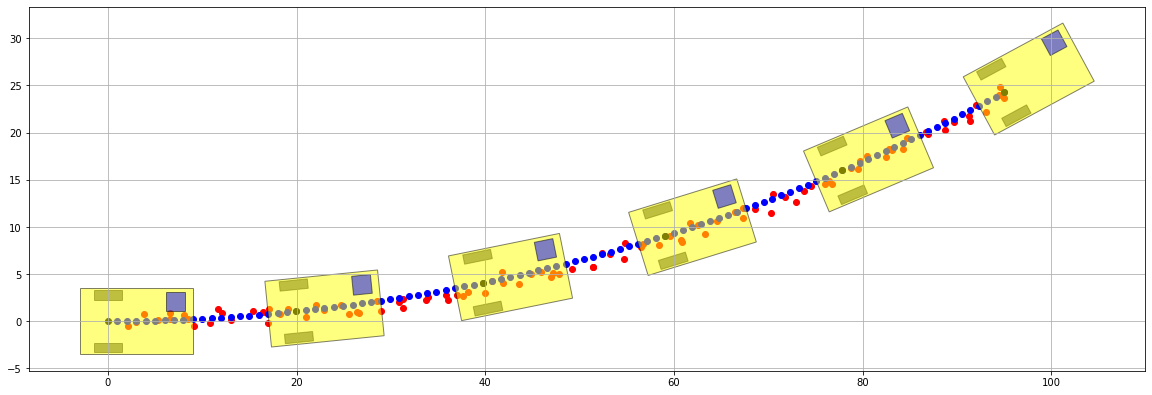

In [7]:
vehicle = Vehicle(10.0,0.05,0.1)

vehicle.InitPosition(0, 0, 0)

fig,ax = plt.subplots(figsize=[20,20])

vehicle.PlotCurrentVehiclePosition(ax, alpha=0.5)

for i in range(1,100,1):
    state, true_state = vehicle.UpdateOneStep()
    #print(i,":",state)

    ax.scatter(state[0], state[1], color="red")
    ax.scatter(true_state[0], true_state[1], color="blue")
    if i%20 == 0:
        print(i)
        vehicle.PlotCurrentVehiclePosition(ax, alpha=0.5)

vehicle.PlotCurrentVehiclePosition(ax, alpha=0.5)

ax.grid()
ax.axis('auto')
ax.set_aspect('equal')


## Kalman Filter Test


In [8]:
kf = KalmanFilter()


In [9]:
kf = KalmanFilter()

dt = 0.1
kf.F = matrix([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]])

In [10]:
kf.H = matrix([[1,0,0,0],[0,1,0,0]])
kf.R = matrix([[0.1,0],[0,0.1]])
kf.I = matrix([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])

In [11]:
kf.x = matrix([[4],[12],[0],[0]])
kf.P = matrix([[1,0,0,0],[0,1,0,0],[0,0,10,0],[0,0,0,10]])

In [12]:
kf.x.show()
kf.P.show()
kf.F.show()
kf.H.show()
kf.R.show()
kf.I.show()

[4]
[12]
[0]
[0]
 
[1, 0, 0, 0]
[0, 1, 0, 0]
[0, 0, 10, 0]
[0, 0, 0, 10]
 
[1, 0, 0.1, 0]
[0, 1, 0, 0.1]
[0, 0, 1, 0]
[0, 0, 0, 1]
 
[1, 0, 0, 0]
[0, 1, 0, 0]
 
[0.1, 0]
[0, 0.1]
 
[1, 0, 0, 0]
[0, 1, 0, 0]
[0, 0, 1, 0]
[0, 0, 0, 1]
 


## KF + Vehicle Motion Test






theta/dt =  0.28647889756541167
pos uncertainity: 0.5
noise: 1


IndexError: index 1 is out of bounds for axis 0 with size 1

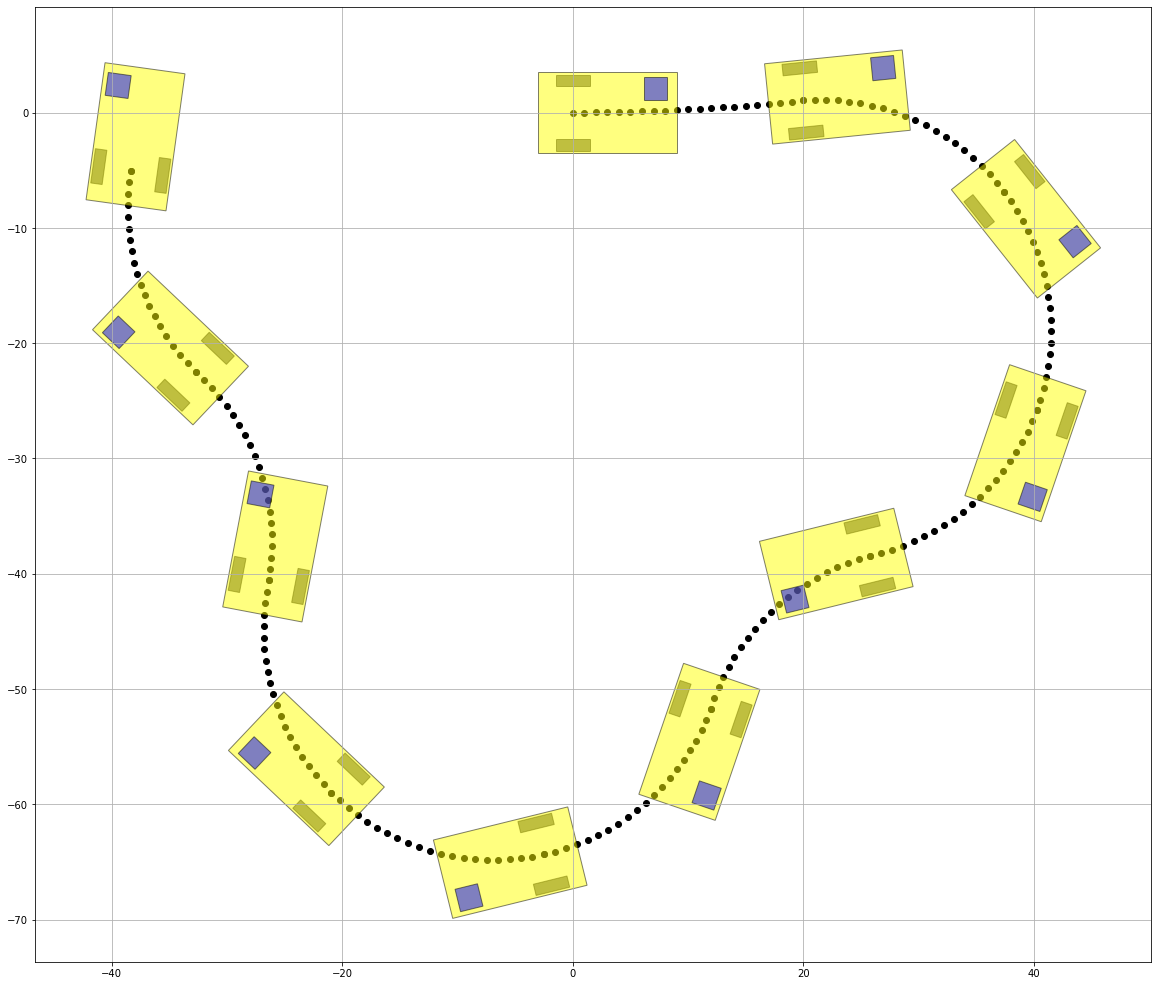

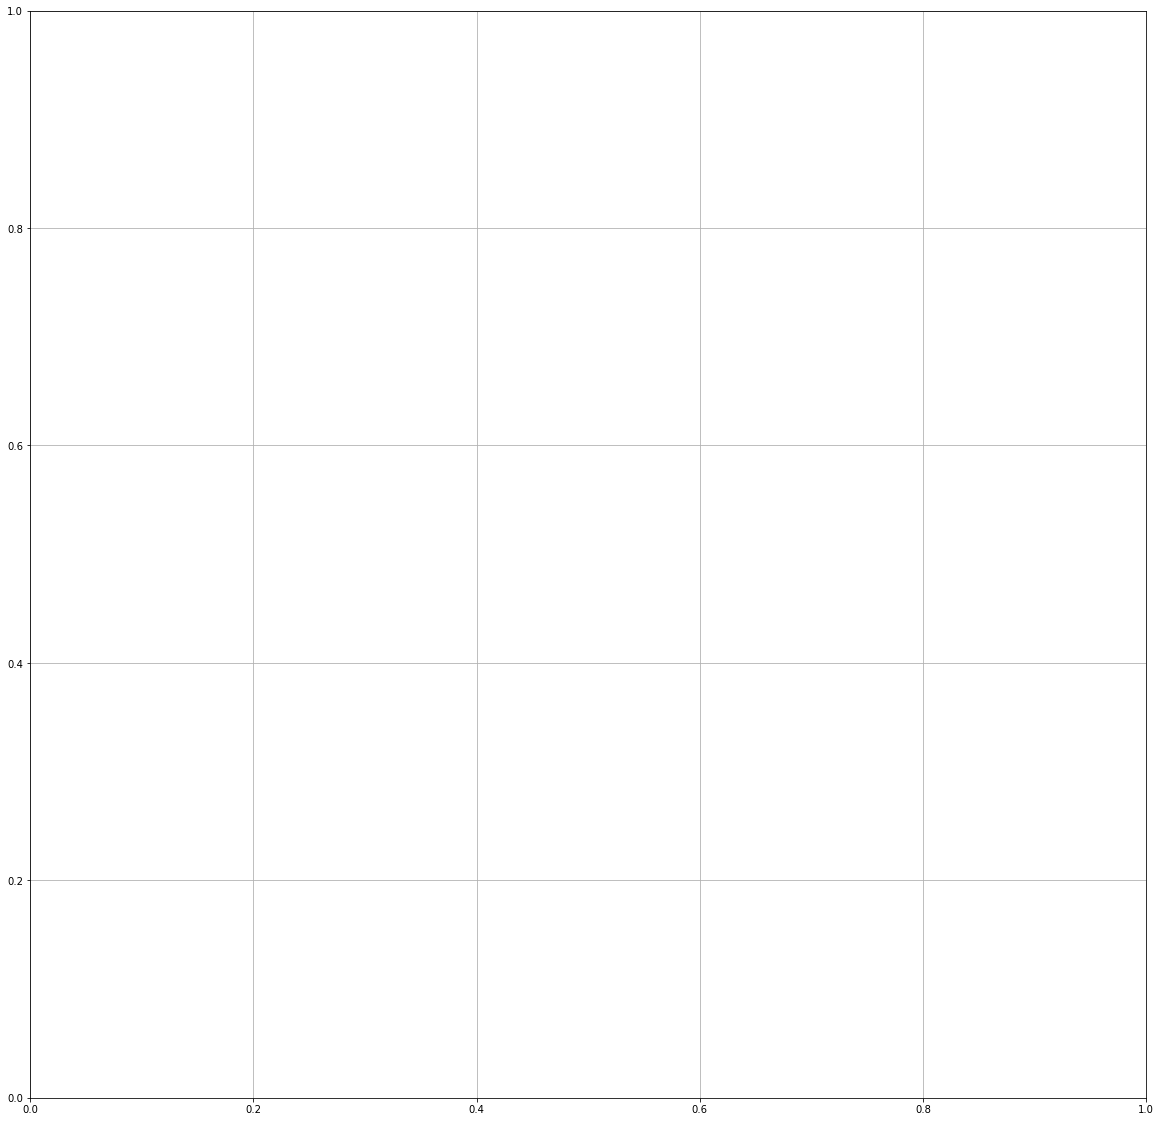

In [51]:

kf = KalmanFilter()
dt = 0.1
#kf.F = matrix([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]])
#kf.H = matrix([[1,0,0,0],[0,1,0,0]])

x_param = 0.1
y_param = 0.0
#measurements = [[ x_param * x * sin(x*pi/720), y_param * x * cos(x*pi/720)] for x in range(0,100)]
measurements = []
estimations = []


vehicle = Vehicle(10.0,0.05,0.1)

vehicle.InitPosition(0, 0, 0)
vehicle.SetNoise(1.0, 0.2)

fig,ax = plt.subplots(figsize=[20,20])
fig2,ax2 = plt.subplots(figsize=[20,20])

vehicle.PlotCurrentVehiclePosition(ax, alpha=0.5)

for i in range(1,200,1):
    state, true_state = vehicle.UpdateOneStep()

    measurements.append([state[0],state[1], 0])

    if(i == 0):
        ax.scatter(state[0], state[1], color="red", alpha=0.5, s=1 ,label="measurement")
        ax.scatter(true_state[0], true_state[1], alpha=0.5, s=1 , color="black", label="ground_truth")

    #ax.scatter(state[0], state[1], color="black")
    ax.scatter(true_state[0], true_state[1], color="black")
    if i%20 == 0:
        #print(i)
        vehicle.PlotCurrentVehiclePosition(ax, alpha=0.5)
        if i%80 == 0:
            vehicle.ChangeAngularVelocity(0.5)
        else:
            vehicle.ChangeAngularVelocity(-0.5)

vehicle.PlotCurrentVehiclePosition(ax, alpha=0.5)

ax.grid()
ax.axis('auto')
ax.set_aspect('equal')

ax2.grid()

for noise in range(1, 2, 1):
    measurement_noise = 0.1
    pos_uncert =  0.5
    vel_uncert =  0.3

    process_uncert = 0.01

    print("pos uncertainity:", pos_uncert)
    print("noise:", noise)
    x = []
    y = []

    timestamps = []
    dists = []
    updated_dists = []
    updated_maha_dists = []
    updated_measurements = []
    unupdated_measurements = []

#measurement_noise = 10.0
    #kf.R = matrix([[2 * measurement_noise,0],[0,measurement_noise]])
    #kf.I = matrix([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
    #kf.x = matrix([[0],[0],[0],[0]])
    #kf.Q = matrix([[process_uncert, 0, 0, 0], 
    #                [0, process_uncert, 0, 0],
    #                [0, 0, process_uncert, 0],
    #                [0, 0, 0, process_uncert]
    #                ])
    #kf.P = matrix([[pos_uncert,0,0,0],
    #               [0,pos_uncert,0,0],
    #               [0,0,vel_uncert,0],
    #               [0,0,0,vel_uncert]]
    #               )

    kf.R = np.matrix([[2 * measurement_noise,0],[0,measurement_noise]])
    kf.x = np.matrix([[0],[0],[0],[0]])
    kf.I = np.identity(4)
    kf.Q = np.matrix([[process_uncert, 0, 0, 0], 
                    [0, process_uncert, 0, 0],
                    [0, 0, process_uncert, 0],
                    [0, 0, 0, process_uncert]
                    ])
    kf.P = np.matrix([[pos_uncert,0.1,0,0],
                   [0.1,pos_uncert,0,0],
                   [0,0,vel_uncert,0],
                   [0,0,0,vel_uncert]]
                   )
    kf.F = np.matrix([
                    [1, 0, dt, 0],
                    [0, 1, 0, dt],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]
                    ])
                    
    kf.H = np.matrix([[1, 0, 0, 0], [0, 1, 0, 0]])
    kf.u = np.matrix([[0], [0], [0], [0]])

    for i in range(len(measurements)):
        kf.Prediction(matrix([[0],[0],[0],[0]]))
        #if i % 50 == 0:
        #    print("Predict P:")
        #    kf.P.show()

        #print("===Measurement===")
        maha_dist = kf.CalcMaharanobisDist2D(measurements[i])
        dist = kf.CalcEuclideanDist2D(measurements[i])
        #print("Maharanobis:", type(maha_dist) , ":", maha_dist)

        timestamps.append((i * dt))
        dists.append(maha_dist)

        #print(measurements[i])
        kf.MeasurementUpdate(measurements[i][0:2])
        #ellipse_x, ellipse_y = kf.GetErrorEllipsePoints(9.21)
        ellipse = kf.GetErrorEllipsePoints(0.95)

        ax.add_patch(ellipse)        
        updated_dists.append(dist)

        if maha_dist < 9.21:

            updated_maha_dists.append(maha_dist)
            #updated_measurements.append(measurements[i])
            #ax.plot(target_x, target_y, color="red")
            #ax.scatter(updated_measurements[:][0], updated_measurements[:][1], color="red", size=3)
            #kf.MeasurementUpdate(measurements[i])
            measurements[i][2] = 1
        else:
            updated_maha_dists.append(0.0)
            measurements[i][2] = 0
            
            #ax.plot(target_x, target_y, color="blue")
            #ax.scatter(unupdated_measurements[:][0], unupdated_measurements[:][1], color="blue", size=3)
            #unupdated_measurements.append(measurements[i])



        x.append(kf.x[0,0])
        y.append(kf.x[1,0])



    label_name = "Noise:" + str(noise)

    ax.plot(x,y,label=label_name, color="cyan")
    #ax.scatter(estimations[:][0], estimations[:][1], label="KF Estimation", color="cyan")
    #ax.plot(x,y,alpha=1.0)
    for measurement in measurements:
        if measurement[2] == 1:
            ax.scatter(measurement[0], measurement[1], color="red")
        else:
            ax.scatter(measurement[0], measurement[1], color="blue")


    ax2.bar(timestamps, dists, color="cyan", width=dt)
    ax2.bar(timestamps, updated_maha_dists, color="orange", width=dt, alpha= 0.7)
    fig2.savefig("maha_dist.png")

    

#for m in measurements:
#    ax.scatter(m[0],m[1],color="red",s=5)

ax.legend()


major_ticks = np.linspace(-100, 100, 5)
minor_ticks = np.linspace(-100, 100, 21)
print("major:", major_ticks)
print("minor:", minor_ticks)
ax.grid(which="major", color="orange", alpha=0.9)
ax.grid(which="minor", color="gray", alpha=0.6)
ax.set_xticks( major_ticks, minor=False)
ax.set_xticks( minor_ticks, minor=True)
ax.set_yticks( major_ticks, minor=False)
ax.set_yticks( minor_ticks, minor=True)
ax.minorticks_on()
ax.set_xlim(-60,60)
ax.set_ylim(-100,100)
   

## Try with Polar Measurement


In [14]:
def CartesianToPolar( x, y):

    range = sqrt(x*x + y*y)
    phi = atan2(y, x)

    if range < 0.00001:
        range = 0.00001

    return([range,phi])

def PolorToCartesian( range, phi):

    x = range * cos(phi)
    y = range * sin(phi)

    return([x,y])
    



theta/dt =  0.28647889756541167
0
20
40
60
80
100
120
140
160
180
major: [-100.  -50.    0.   50.  100.]
minor: [-100.  -90.  -80.  -70.  -60.  -50.  -40.  -30.  -20.  -10.    0.   10.
   20.   30.   40.   50.   60.   70.   80.   90.  100.]
noise: 0


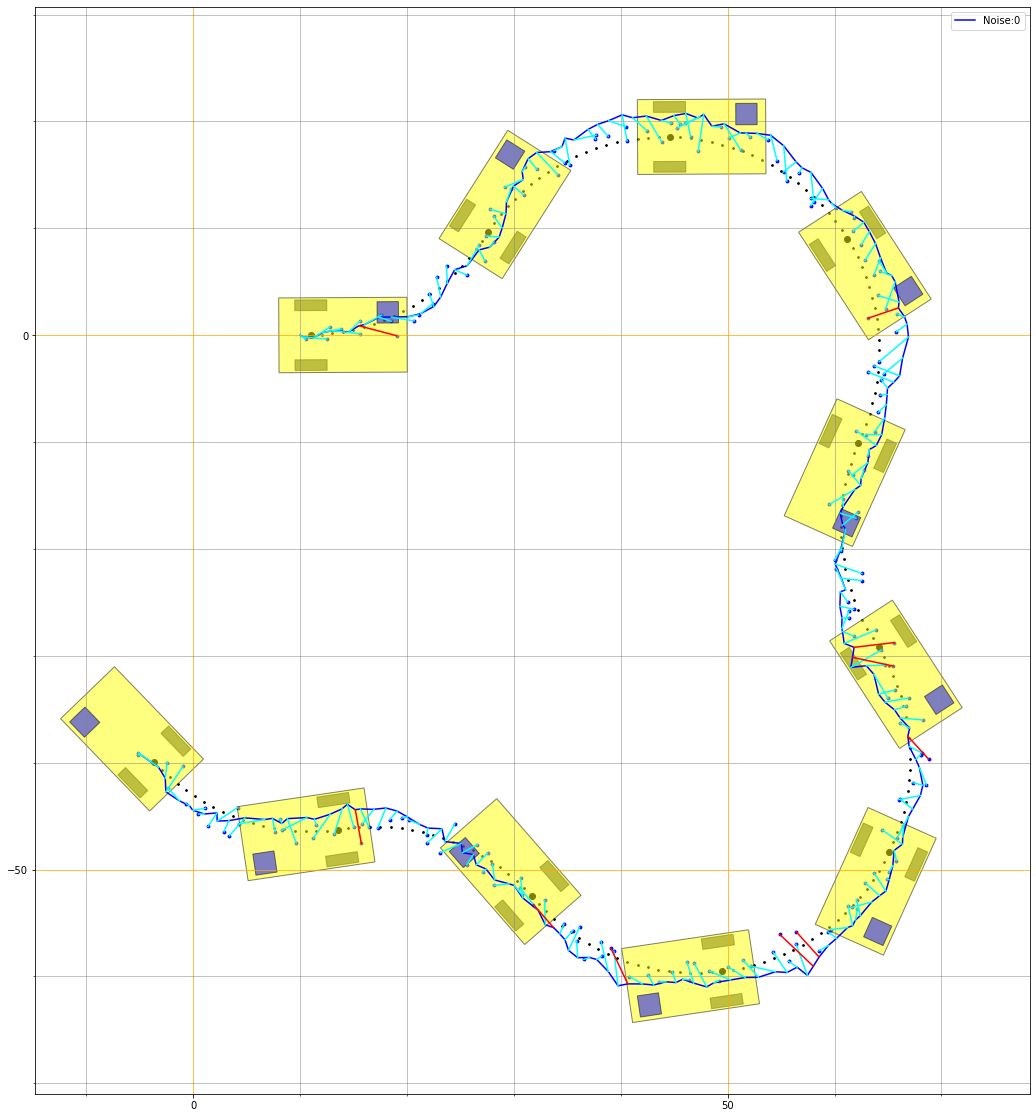

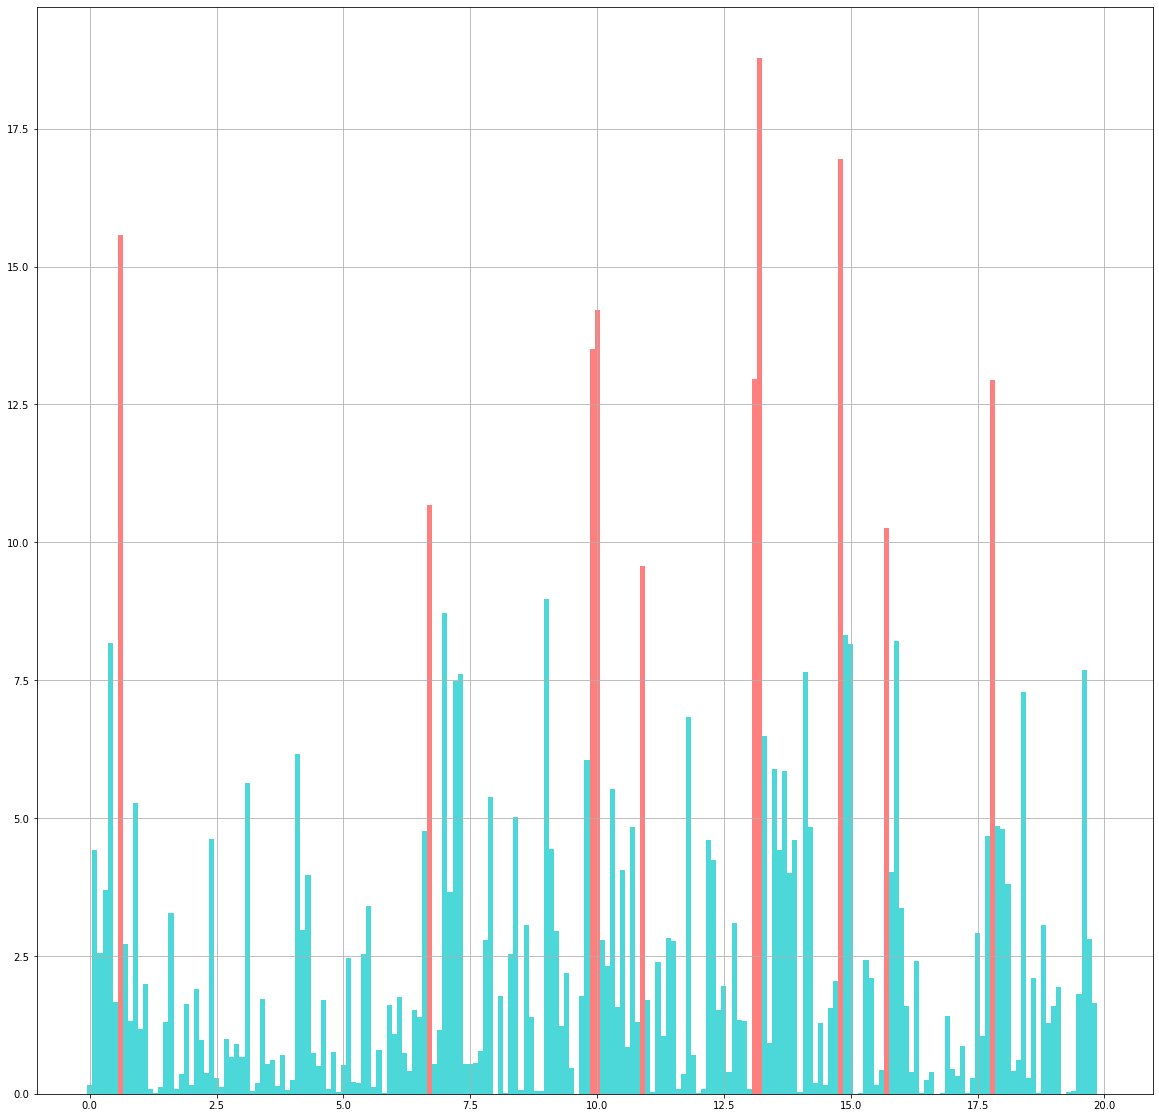

In [77]:

init_pos = [10,0,0]
init_vel = 10.0
init_w = 0.05
dt = 0.1

measurement_noise = 1

range_uncert = 1.5
theta_uncert = 1.0
vel_uncert =  10.0
process_uncert = 0.2


kf = KalmanFilter()
#kf.F = matrix([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]])
#kf.H = matrix([[1,0,0,0],[0,1,0,0]])

x_param = 0.1
y_param = 0.0
#measurements = [[ x_param * x * sin(x*pi/720), y_param * x * cos(x*pi/720)] for x in range(0,100)]
measurements = []
timestamps = []

vehicle = Vehicle( init_vel, init_w, dt)
vehicle.InitPosition(init_pos[0], init_pos[1], init_pos[2])
vehicle.SetNoise(1.5, 0.1);

fig,ax = plt.subplots(figsize=[20,20])
fig2,ax2 = plt.subplots(figsize=[20,20])

updated_maha_dists = []
all_maha_dists = []
updated_pos = []
unupdated_pos = [] # x[0], x[1], m[0], m[1]
#vehicle.PlotCurrentVehiclePosition(ax, alpha=0.5)

for i in range( 200):
    state, true_state = vehicle.UpdateOneStep()

    measurements.append([state[0],state[1], 0])

    #ax.scatter(state[0], state[1], color="red")
    ax.scatter(true_state[0], true_state[1], color="black", s=3)
    if i%20 == 0:
        print(i)
        vehicle.PlotCurrentVehiclePosition(ax, alpha=0.5)
        if i%80 == 0:
            vehicle.ChangeAngularVelocity(0.5)
        else:
            vehicle.ChangeAngularVelocity(-0.5)

vehicle.PlotCurrentVehiclePosition(ax, alpha=0.5)

ax.set_aspect('equal')


major_ticks = np.linspace(-100, 100, 5)
minor_ticks = np.linspace(-100, 100, 21)
print("major:", major_ticks)
print("minor:", minor_ticks)


for noise in range(1):

    print("noise:", noise)
    x = []
    y = []


    measurement = measurements[0]

    kf.R = np.matrix([[2 * measurement_noise,0],[0,measurement_noise]])
    init_measurement = CartesianToPolar( init_pos[0], init_pos[1])
    kf.x = np.matrix([[init_measurement[0]],[init_measurement[1]],[0],[0]])
    kf.I = np.identity(4)
    kf.Q = np.matrix([[process_uncert, 0, 0, 0], 
                    [0, process_uncert, 0, 0],
                    [0, 0, process_uncert, 0],
                    [0, 0, 0, process_uncert]
                    ])
    kf.P = np.matrix([[range_uncert,0.1,0,0],
                   [0.1,theta_uncert,0,0],
                   [0,0,vel_uncert,0],
                   [0,0,0,vel_uncert]]
                   )
    kf.F = np.matrix([
                    [1, 0, dt, 0],
                    [0, 1, 0, dt],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]
                    ])
                    
    kf.H = np.matrix([[1, 0, 0, 0], [0, 1, 0, 0]])
    kf.u = np.matrix([[0], [0], [0], [0]])


    for i in range(len(measurements)):

        kf.Prediction(np.matrix([[0],[0],[0],[0]]))

        #print("===Measurement===")

        measurement = CartesianToPolar(measurements[i][0], measurements[i][1])

        maha_dist = kf.CalcMaharanobisDist2D(measurement)
        timestamps.append((i * dt))
        all_maha_dists.append(maha_dist)

        cartesian_state = PolorToCartesian(kf.x[0,0], kf.x[1,0])

        if maha_dist < 9.21:

            updated_maha_dists.append(maha_dist)
            updated_pos.append([cartesian_state[0], cartesian_state[1], measurements[i][0], measurements[i][1]])
            
            measurements[i][2] = 1
            ec = ErrorEllipse2D(kf.P, 0.99)
            cartesian_state = PolorToCartesian(kf.x[0,0], kf.x[1,0])
            ellipse = kf.GetErrorEllipsePointsWithSelectedPos(cartesian_state[0], cartesian_state[1], 0.95, color="cyan")
            kf.UpdatePolorMeasurement(measurement)
        else:
            updated_maha_dists.append(0.0)
            unupdated_pos.append([cartesian_state[0], cartesian_state[1], measurements[i][0], measurements[i][1]])
            measurements[i][2] = 0
            ellipse = kf.GetErrorEllipsePointsWithSelectedPos(cartesian_state[0], cartesian_state[1], 0.95, color="red")
            





        #ax.add_patch(ellipse)        

        x.append(cartesian_state[0])
        y.append(cartesian_state[1])

        #print(i,":", measurements[i], " --> ", x[-1],y[-1])



    label_name = "Noise:" + str(noise)

    ax.plot(x,y,label=label_name, color="blue")

    #ax.plot(x,y,alpha=1.0)

for m in measurements:
    ax.scatter(m[0],m[1],color="blue",s=8)

for pos in updated_pos:
    tmp_x = [ pos[0], pos[2] ]
    tmp_y = [ pos[1], pos[3] ]
    ax.plot( tmp_x, tmp_y, color="cyan")

for pos in unupdated_pos:
    tmp_x = [ pos[0], pos[2] ]
    tmp_y = [ pos[1], pos[3] ]
    ax.plot( tmp_x, tmp_y, color="red")

ax.legend()

#ax.set_xlim(0,100)
#ax.set_ylim(0,100)
#ax.grid()

ax.grid(which="major", color="orange", alpha=0.9)
ax.grid(which="minor", color="gray", alpha=0.6)
ax.set_xticks( major_ticks, minor=False)
ax.set_xticks( minor_ticks, minor=True)
ax.set_yticks( major_ticks, minor=False)
ax.set_yticks( minor_ticks, minor=True)
ax.minorticks_on()
ax.set_xlim(np.min(x) - 10, np.max(x) + 10)
ax.set_ylim(np.min(y) - 10, np.max(y) + 10)

ax2.bar(timestamps, all_maha_dists, color="red", width=dt, alpha= 0.5)
ax2.bar(timestamps, updated_maha_dists, color="cyan", width=dt, alpha= 0.7)
ax2.grid()
fig2.savefig("polar_maha_dist.png")
   